<a href="https://colab.research.google.com/github/LCaravaggio/ClaseTimeSeries/blob/main/Ejercicio2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercicio 2

La primera parte es toda igual.

Primero importamos todas las librerías necesarias, solo que esta vez incluimos la librería statsmodels

In [51]:
from google.colab import drive
import json

import requests
from requests.auth import HTTPBasicAuth

import pandas as pd

import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels

Por una cuestión de seguridad, tenemos la clave de la API guardada en el drive, así que accedemos a la misma.

In [12]:
drive.mount('/content/drive', force_remount=True)
with open("/content/drive/My Drive/alphacast.json", 'r') as f:
    api_token= json.load(f)

Mounted at /content/drive


In [ ]:
# Definir user key para la API
user_key = api_token["key"]

Ahora vamos a tomar la serie sin estacionalidad, en vez de la serie original como hicimos en el Ejercicio 1. 

In [59]:
# EMAE
emae = requests.get('https://api.alphacast.io/datasets/5331/data?apiKey='+user_key+'&&$format=csv', auth=HTTPBasicAuth(user_key, ''))
open('emae.csv','wb').write(emae.content)
emae = pd.read_csv('emae.csv',delimiter = ',')

In [60]:
emae['Date'] = pd.to_datetime(emae['Date'])
emae.set_index('Date', inplace = True)
emae = emae['Emae - sa_orig - current_prices_mom']
emae.columns = ['Emae - sa_orig - current_prices_mom']
emae = emae.loc['2016-02-01':]

In [61]:
# IPI
ipi = requests.get('https://api.alphacast.io/datasets/5679/data?apiKey='+user_key+'&&$format=csv', auth=HTTPBasicAuth(user_key, ''))
open('ipi.csv','wb').write(ipi.content)
ipi = pd.read_csv('ipi.csv',delimiter = ',')

In [62]:
ipi['Date'] = pd.to_datetime(ipi['Date'])
ipi.set_index('Date', inplace = True)
ipi = ipi['IPI - sa_MoM']
ipi.columns = ['IPI - sa_mom']
ipi = ipi.loc['2016-02-01':]

In [63]:
# ISAC
isac = requests.get('https://api.alphacast.io/datasets/5565/data?apiKey='+user_key+'&&$format=csv', auth=HTTPBasicAuth(user_key, ''))
open('isac.csv','wb').write(isac.content)
isac = pd.read_csv('isac.csv',delimiter = ',')

In [64]:
isac['Date'] = pd.to_datetime(isac['Date'])
isac.set_index('Date', inplace = True)
isac = isac['Nivel general - sa_MoM']
isac.columns = ['Nivel general - sa_MoM']
isac = isac.loc['2016-02-01':]

Preparamos una función para graficar

In [40]:
sns.set_theme(style='darkgrid')
def graficar(variable):
    fig = sns.lineplot(x=variable.index, y=variable)
    plt.title(variable.name)
    plt.xlabel("Año")
    plt.savefig('%s.png'%variable.name)
    return fig

Y la graficamos. Si bien la serie se estancadesde 2011, claramente su media depende del tiempo, por lo que no podemos quedarnos tranquilos que sea estacionaria. Por otro lado se observa su comportamiento estacional ya que lo que trajimos fue la serie original y no la desestacionalizada. 

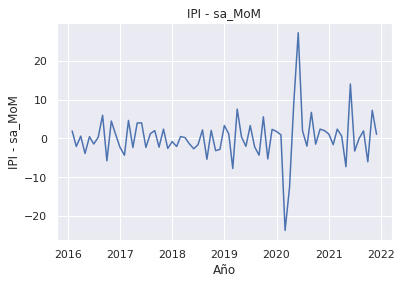

In [41]:
graficar(ipi)

Chequeamos si la serie es estacionaria con el test de Dickey-Fuller aumentado del paquete Statsmodels. 

La H0 del modelo es que la serie tiene raíz unitaria, es decir que no es estacionaria. 

Como el p-value <= 0.05 quiere decir que se puede rechazar la H0 y por tanto se asume que la serie es estacionaria. 

In [73]:
from statsmodels.tsa.stattools import adfuller
res=adfuller(emae)
print('ADF Statistic: %f' % res[0])
print('p-value: %f' % res[1])
print('Critical Values:')
for key, value in res[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.223268
p-value: 0.000000
Critical Values:
	1%: -3.530
	5%: -2.905
	10%: -2.590


In [74]:
frame = { 'EMAE': emae, 'IPI': ipi , 'ISAC': isac}
df = pd.DataFrame(frame)

In [75]:
results = smf.ols('EMAE ~ IPI + ISAC', data=df).fit()

In [76]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   EMAE   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     89.59
Date:                Fri, 11 Feb 2022   Prob (F-statistic):           1.17e-19
Time:                        18:45:01   Log-Likelihood:                -131.32
No. Observations:                  70   AIC:                             268.6
Df Residuals:                      67   BIC:                             275.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1403      0.194     -0.725      0.4